### **Libraries**


In [0]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_predict

In [0]:
!pip install qiskit

     |████████████████████████████████| 6.7MB 2.6MB/s 
     |████████████████████████████████| 23.4MB 1.7MB/s 
     |████████████████████████████████| 163kB 45.0MB/s 
     |████████████████████████████████| 174kB 47.1MB/s 
     |████████████████████████████████| 1.9MB 42.4MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 768kB 37.4MB/s 
     |████████████████████████████████| 5.8MB 40.2MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 296kB 43.0MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 26.0MB 1.6MB/s 
     |████████████████████████████████| 573kB 33.9MB/s 
     |████████████████████████████████| 2.7MB 39.9MB/s 
  Created wheel for qiskit: filename=qiskit-0.19.2-cp36-none-any.whl size=2896 sha256=7d7e1e0d9b8ed5dc4d831470f2ac5cf89db57820a88f821bbb23690565804a45
  Stored in directory: /root/.cache/pip/wheels/d8/29/6e/e065f721b42fe704

In [0]:
import qiskit
from qiskit import Aer
from qiskit import IBMQ
from qiskit import BasicAer
from qiskit.ml.datasets import *
from qiskit.circuit.library import ZZFeatureMap
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QSVM

### **Loading the datasets**

The dataset is the Breast Cancer Wisconsin (Diagnostic) Data Set, imported using the native sklearn load_breast_cancer method. 
It contains 569 instances and 32 attributes. Principal Component Analysis is performed to select those features that contain about 95% of the total variance and subsequently the data is normalised using the StandardScaler() method


In [0]:
data = load_breast_cancer()

In [0]:
X_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = pd.DataFrame(data.target, columns=["Target"])

In [0]:
dat = pd.concat([X_data, y_data], axis=1, join='inner')

In [0]:
reduced_data = dat.sample(n=100)

In [0]:
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(reduced_data[data.feature_names], reduced_data["Target"], test_size=20)

In [0]:
X_train, X_test, y_train_std, y_test_std = train_test_split(dat[data.feature_names], dat["Target"], test_size=1/3)

In [0]:
pca = PCA(n_components=4)
scaler = StandardScaler()

data_transformer = Pipeline([
                             ("pca", pca),
                             ("scaler", scaler),
])

In [0]:
X_train_std = data_transformer.fit_transform(X_train)
X_test_std = data_transformer.fit_transform(X_test)

X_train_red = data_transformer.fit_transform(X_train_red)
X_test_red = data_transformer.fit_transform(X_test_red)


In [0]:
X_train_red.shape


(80, 4)

In [0]:
X_train_std.shape

(379, 4)

### **Classical SVM (Full Dataset, 4 features)**

In this section, we implement a classical Support Vector Machine binary classifer.

In [0]:
classical_svm_clf = SVC()

In [0]:
%time
classical_svm_clf.fit(X_train_std, y_train_std)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.44 µs


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_train_pred_std = cross_val_predict(classical_svm_clf, X_train_std, y_train_std, cv=5)

In [0]:
fpr, tpr, thresholds = roc_curve(y_train_std, y_train_pred_std)

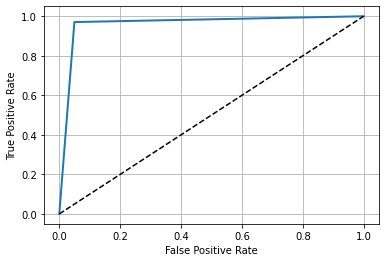

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

In [0]:
y_pred_std = classical_svm_clf.predict(X_test_std)
y_pred_std_inv = 1 - y_pred_std
accuracy = accuracy_score(y_test_std, y_pred_std)
inv_accuracy = accuracy_score(y_test_std, y_pred_std_inv)

In [0]:
print("Classical accuracy on test set: {0}%".format(np.round(accuracy*100, 2)))
print("Classical accuracy on test set (inverted predictions): {0}%".format(np.round(inv_accuracy*100, 2)))

Classical accuracy on test set: 80.0%
Classical accuracy on test set (inverted predictions): 20.0%


In [0]:
conf_matrix = confusion_matrix(y_test_std, y_pred_std)

In [0]:
conf_matrix

array([[ 57,  14],
       [ 17, 102]])

### **Classical SVM (Reduced Dataset, 2 features)**

In [0]:
classical_svm_clf_red = SVC()

In [0]:
%time
classical_svm_clf_red.fit(X_train_red, y_train_red)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.48 µs


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [0]:
y_train_pred_red = cross_val_predict(classical_svm_clf_red, X_train_red, y_train_red, cv=5)

In [0]:
fpr, tpr, thresholds = roc_curve(y_train_red, y_train_pred_red)

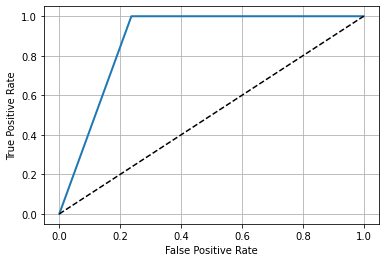

In [0]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()

plot_roc_curve(fpr, tpr)
plt.show()

In [0]:
y_pred_red = classical_svm_clf_red.predict(X_test_red)
y_pred_red_inv = 1 - y_pred_red
accuracy = accuracy_score(y_test_red, y_pred_red)
inv_accuracy = accuracy_score(y_test_red, y_pred_red_inv)

In [0]:
print("Classical accuracy on test set: {0}%".format(np.round(accuracy*100, 2)))
print("Classical accuracy on test set (inverted predictions): {0}%".format(np.round(inv_accuracy*100, 2)))

Classical accuracy on test set: 80.0%
Classical accuracy on test set (inverted predictions): 20.0%


In [0]:
conf_matrix = confusion_matrix(y_test_red, y_pred_red)

In [0]:
print(conf_matrix)

[[8 2]
 [2 8]]


### **Quantum SVM (Reduced Dataset, 4 features)**

The quantum SVM algorithm supports a maximum of three features therefore, the dataset has been reduced using PCA to two features and 30 instances, out of which 20 training instances are selected, and the remaining 10 are used as test instances.

In [0]:
qiskit.__version__

'0.14.1'

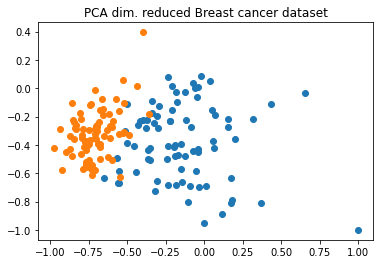

In [0]:
sample_total, training_input, test_input, class_labels = breast_cancer(
    training_size=80,
    test_size=20,
    n=4,
    plot_data=True
)

In [0]:
seed = 10598
feature_dim = 4

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2, entanglement='linear')
qsvm = QSVM(feature_map, training_input, test_input)

In [0]:
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

In [0]:
%time
result = qsvm.run(quantum_instance)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 6.2 µs


In [0]:
print("Quantum accuracy on test set: {0}%".format(round(result['testing_accuracy']*100, 2)))

Quantum accuracy on test set: 77.5%


### **Results**

**Classical Support Vector Machines** — Test Accuracy: 80.00%

**Classical Support Vector Machines (Reduced Dataset)** — Test Accuracy: 80.00%

**Quantum Support Vector Machines:** — Test Accuracy: 77.50%

